# WM391 PMA Additional Help

## Contents

1. Loading data into colab
2. Template for using PyTorch dataloader
3. Saving check points
4. Loading from check points
5. Some architectures to consider
6. Some useful items to explore
7. Template code for training, evaluation, saving and loading models


> **The code in this file is a template that will give you hints and suggestions on possible options. You need to read understand and modify this code for it to work for your case. It will not run without making changes that correspond to your  local setup, and implementing your chosen model.**


*Authors:* Aru Ranjan Singh, Manoj Babu, Mianchu Wang

*Updated:* 02/02/2024

In [14]:
# Loading some useful libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as transforms
import os
import glob
import cv2
from torch.utils.data import Dataset, DataLoader
import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
from PIL import Image

## Loading data into colab

One way is to connect your GDrive.

List of all possible options can be found [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=eikfzi8ZT_rW)

### For the WM391 course work

>*As stated during the final lecture*

1. Download  dataset from Moodle.
2. Ceate folder `WM391` in your Google Drive root directory.
2. Upload CBSD68 to `WM391`.
3. Run the following code to connect your Google Drive.
  ```
  from google.colab import drive
  drive.mount('/content/drive')
  ```
4. When you want to load the files from the dataset, use prefix 'drive/MyDrive/WM391/CBSD68/...'. For example, you should be able to display an edge map by
  ```
  import imageio
  import matplotlib.pyplot as plt

  img = imageio.imread('drive/MyDrive/WM391/CBSD68/')
  plt.imshow(img)
  ```
  Please make sure that you can display the image by exactly the same code. If not, your dataset may be placed in a wrong directory.



In [2]:
# Connecting your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-777a5f32cdd4>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('/content/drive/MyDrive/WM391/CBSD68/noisy10/0000.png')


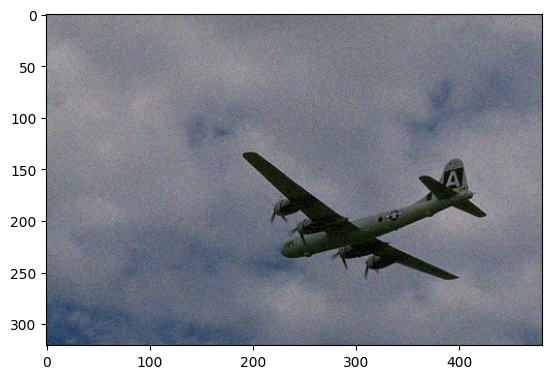

In [3]:
import imageio
import matplotlib.pyplot as plt

img = imageio.imread('/content/drive/MyDrive/WM391/CBSD68/noisy10/0000.png')
plt.imshow(img)

## Enable GPU on colab

As explained in the lab, to enable GPU computaion in Colab by clicking the `Runtime` menu option, then clicking ` change runtime`. *Please refer to previous announcemnts for detailed instructions on how to use a GPU available on your local machine.*


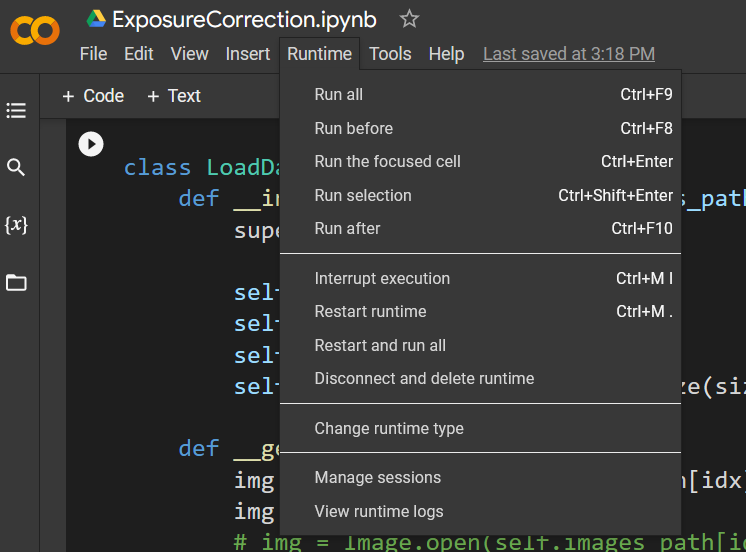

Finally, select GPU from the dialog box.

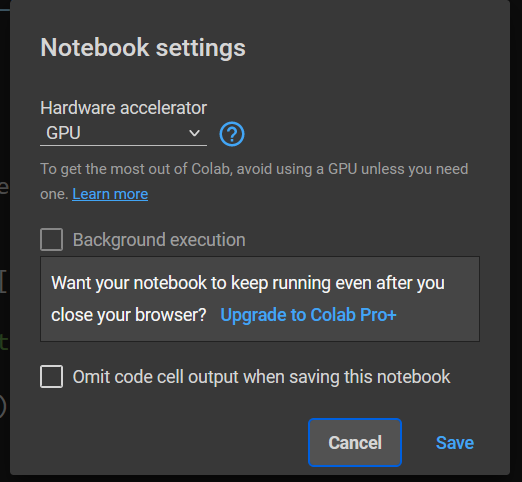


In [4]:
# If a GPU device is available, running the following code should print CUDA as output otherwise it will print CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Setting up your local GPU environment

Some help for using GPU on your local machine (if an Nvidia GPU is available):

The sequence of tasks to enable/use GPU version of PyTorch locally in your machine:

1. Create a new python environment (giving it a new name) by following the same instructions used to create the `WM391` environment used throughout this module (i.e, steps 1-8 there).

2. Install the GPU version of pyTorch by typing the command in the anaconda prompt after activating the new environment:

`conda install pytorch torchvision torchaudio pytorch-cuda=11.6 -c pytorch -c nvidia`

> *For your information:* Complete set of installation options can be found from the offical [website.](https://pytorch.org/get-started/locally/)

3. After installation you can check the availability of GPU version of pyTorch using command: `torch.cuda.is_available()`

If you have access to an older CUDA capable graphics device you can install older compatible pytorch version following official instructions [here](https://pytorch.org/get-started/previous-versions/). **Please note** this may lead to further compatibility or other technical isses, I recommend using colab if the default setup instructions do not work on your machine.

Please update the driver of your graphics card so that it is compatible with the cudatoolkit version installed. Version compatibility is described in detail the following [webpage](https://docs.nvidia.com/deploy/cuda-compatibility/index.html)


# Template for using PyTorch dataset and dataloader

As pointed out in the lab files pyTorch has a `Dataset` module the helps with loading files. In addition to this we can add image file manipulations/transformations to each file when it is loaded into the model.

This modules integrates with the `Dataloader` module that makes splitting the dataset into training, testing and batches automatic.  The code in the following code can be used as template  

In [46]:
# All training files, i.e., Xs
train_X = sorted(glob.glob('/content/drive/MyDrive/WM391/CBSD68/noisy10/*')) # Do not change the path
# Path to folder containing training files, i.e., Ys
train_y = '/content/drive/MyDrive/WM391/CBSD68/original_png/' # Do not change the path

# valid_X = sorted(glob.glob('/content/drive/MyDrive/WM391/BIPED/edges/imgs/test/rgbr/*')) # Do not change the path
# valid_y = '/content/drive/MyDrive/WM391/BIPED/edges/edge_maps/test/rgbr/' # Do not change the path


# defining the custom dataset class
class myCustomDataset(Dataset):
    def __init__(self, x_image_ids, y_images_path):
        super().__init__()

        # size = (64, 64)
        self.x_image_ids = x_image_ids
        self.y_images_path = y_images_path
        self.len = len(x_image_ids)
        # self.transform = transforms.Resize(size) # Resizes the input image

    def __getitem__(self, idx):
        # Each call to myCustomDataset object will return a image according to the id passed to the object,
        # each image returend will be the output from this function, you can modify this to add your own transformations or
        # manipulations. Try to understnad this code and see what is happening here.
        img = cv2.imread(self.x_image_ids[idx])
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ## necessary only to visualise
        # plt.imshow(img)
        img = np.transpose(img, (2, 0, 1)) # converting to channels X width X height
        if img.shape[1] > img.shape[2]:
          img = np.transpose(img, (0, 2, 1)) # rotating the image so that all arrays are of same shape
        # img = self.transform(img)
        # img = img/255.0                # can you reason whether this is important or not?
        img = torch.tensor(img)

        image_name = os.path.basename(self.x_image_ids[idx]).split(".")[0]
        exp_img_path = self.y_images_path + image_name +".png"
        # print(exp_img_path)
        y_image = cv2.imread(exp_img_path)
        # print(img.shape)
        # y_image = cv2.cvtColor(y_image, cv2.COLOR_BGR2RGB)
        # plt.imshow(y_image)
        # y_image = y_image/255.0
        y_image = np.transpose(y_image, (2, 0, 1)) # converting to channels X width X height
        if y_image.shape[1] > y_image.shape[2]:
          y_image = np.transpose(y_image, (0, 2, 1))  # rotating the image so that all arrays are of same shape
        # y_image = self.transform(y_image)
        y_image = torch.tensor(y_image)

        return img, y_image

    def __len__(self):
        return self.len

In [47]:
# Creating our dataset object
noiseDataset = myCustomDataset(train_X, train_y)
# noiseDataset.__getitem__(1)

In [48]:
# Creating our training and test dataset
generator1 = torch.Generator().manual_seed(42)
train_dataset,test_dataset = torch.utils.data.random_split(noiseDataset, [0.8, 0.2], generator=generator1)


We can use the above created dataset object in conjuction with a dataloader that will help load in batches automatically.

In [50]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

# Setting the hyper-parameters THESE VALUES ARE NOT A SUGGESTION, YOU MUST MODIFY THEM ACCORDING TO YOUR CASE
batch_size = 4
num_epochs = 50
lr = 1e-4


# Creating the dataloader object
train_dataloader = DataLoader(
        train_dataset.dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
)

test_dataloader = DataLoader(
        test_dataset.dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
)

## We can test our dataloaders

In [52]:
def viz_loader(n=2):
  count = 1
  for x,y in noiseDataset:
    if count<=n:
      print(x.shape, y.shape)
      # x = x.to(device, dtype=torch.float32)
      # y = y.to(device, dtype=torch.float32)
      count+=1
    else:
      break

def viz_train_loader(n=2):
  count = 1
  for x,y in train_dataloader:
    if count<=n:
      print(x.shape, y.shape)
      # x = x.to(device, dtype=torch.float32)
      # y = y.to(device, dtype=torch.float32)
      count+=1
    else:
      break


In [53]:
viz_loader()
viz_train_loader()
# batch= iter(train_dataloader)
# images, labels = batch.next()


torch.Size([3, 321, 481]) torch.Size([3, 321, 481])
torch.Size([3, 321, 481]) torch.Size([3, 321, 481])
torch.Size([4, 3, 321, 481]) torch.Size([4, 3, 321, 481])
torch.Size([4, 3, 321, 481]) torch.Size([4, 3, 321, 481])


In [51]:
## An other way of visualising
dd,ff = next(iter(train_dataloader))
print(dd.shape, ff.shape)

torch.Size([4, 3, 321, 481]) torch.Size([4, 3, 321, 481])


## Create your model


## Some architectures to consider
> While there are many new architectures for this task. Based on the topic covered in the lecure, CNN based models would be easier to explore. Since in this task both input and output are image, a encoder-decoder type architecture will be best suited, popular options are DnCNN, uNet or some combinations of both, for instance UDnCNN.  If you want to explore further pix2pix and cycleGAN could be useful as well. They all have PyTorch implementations.

As described in the brief we don't have to create an new architecture, please choose an architecture that is appropriate for the task and demonstrate your understanding of it.

## Important note:
> Marks are awarded for a combination of criteria and not any one single criterion. For instance, novelty of architecure or performance of network.

So please do not focus on just one criteria, try to meet high tresholds in as many aspects as possible by demonstrating critical understanding.

After you define your model, lets call it `exNet` you can move it to GPU.

In [ ]:
# Transfer the `exNet()` model you created to the GPU using the following code.
model = exNet() # model needs to be implemented!
model = model.to(device)

## Choose your optimiser and loss function

In [ ]:
optimizer = # torch.optim.xxx
loss_fn = # nn.xx

## Saving check points
It is always good to save your model training progress so that if trainig stops for any reason you dont dont have to start from scratch. This is also helpful as your colab session might disconnect if you are inactive for long periods.
> Official PyTorch help [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


In [ ]:
# The path where the file will be saved
checkpoint_path = "drive/MyDrive/WM391/checkpoint.pth"


## Defining the training function

### Some key manipuations to consider to make training faster

Work with a smaller dataset, reduce the size of the image so that training can be faster. There are other options available for you to explore regarding this as well ...


In [ ]:
def train_model(model, customDataLoader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()   # What does this do? Is it necessary?
    for x, y in customDataLoader:  # what is happening here?
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
#       x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor) # what does this do?

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

## Evaluation function

In [ ]:
def evaluate(model, customDataLoader, loss_fn, device):
    epoch_loss = 0.0

    model.eval() # What dose this do? Is it necessary?
    with torch.no_grad():
        for x, y in customDataLoader:  # what is happening here?
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor) # what does this do?

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

## Training evaluation and saving loop

In [ ]:
train = []
valid = []

best_test_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = train_model(model, train_dataloader, optimizer, loss_fn, device)
    test_loss = evaluate(model, test_dataloader, loss_fn, device)

    train.append(train_loss)
    valid.append(test_loss)

    if test_loss < best_test_loss:
        data_str = f"Valid loss improved from {best_test_loss:2.4f} to {test_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_test_loss = test_loss
        torch.save(model.state_dict(), checkpoint_path)

    data_str = f'Epoch: {epoch+1:02}\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {test_loss:.3f}\n'
    print(data_str)

## Loading from check points

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
# If you just want to use a pretrained model, set the model to eval() mode,
#so weights are not accidentaly updated or modified
model.eval()

## Some other useful content, but not applicable for this coursework

### Extracting a zip file from within colab to a location in GDrive, as uploading single image files can be time consuming

Can be acheived by the following command:
`!unzip "path to the zip file" -d "path to the folder to extract the files"`

Path can be obtained interactively by using the sidebar in colab to locate the folder and clicking the three dots at the end of the folder name as shown in the figure below:

![Folder Path](https://github.com/manojkumrb/imagesForCoalb/blob/main/folder%20path.png?raw=true)

See the example path for my google drive below.

In [ ]:
!unzip "drive/MyDrive/WM391/training.zip" -d "drive/MyDrive/WM391/training/"

## Refereces
Kaggle